In [1]:
# PHÁT BIỂU BÀI TOÁN
# Bài toán phân loại tin nhắn SMS thành hai loại: spam (tin rác) và ham (tin bình thường)
# Mục tiêu: Xây dựng và so sánh mô hình Naive Bayes và Logistic Regression để tự động phát hiện tin nhắn SMS spam
# Dữ liệu: Bộ dữ liệu SMS Spam Collection v.1 với 5,574 tin nhắn tiếng Anh đã được gán nhãn ham hoặc spam

# NHẬP THƯ VIỆN VÀ TẢI DỮ LIỆU
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import string
from nltk.corpus import stopwords
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Tạo hàm tiền xử lý văn bản cho toàn bộ dữ liệu
def text_process(mess):
    # Loại bỏ dấu câu
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # Loại bỏ stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [4]:
# Đọc dữ liệu
message = pd.read_csv("SMSSpamCollection.csv", sep='\t', names=["labels", "message"])
print(f"Kích thước dữ liệu: {message.shape}")

# Kiểm tra phân phối của nhãn
print("\nPhân phối của nhãn:")
print(message['labels'].value_counts())
print(f"Tỉ lệ tin nhắn spam: {message['labels'].value_counts(normalize=True)['spam']:.2%}")


Kích thước dữ liệu: (5572, 2)

Phân phối của nhãn:
labels
ham     4825
spam     747
Name: count, dtype: int64
Tỉ lệ tin nhắn spam: 13.41%


In [5]:
# Thêm cột độ dài tin nhắn
message['length'] = message['message'].apply(len)

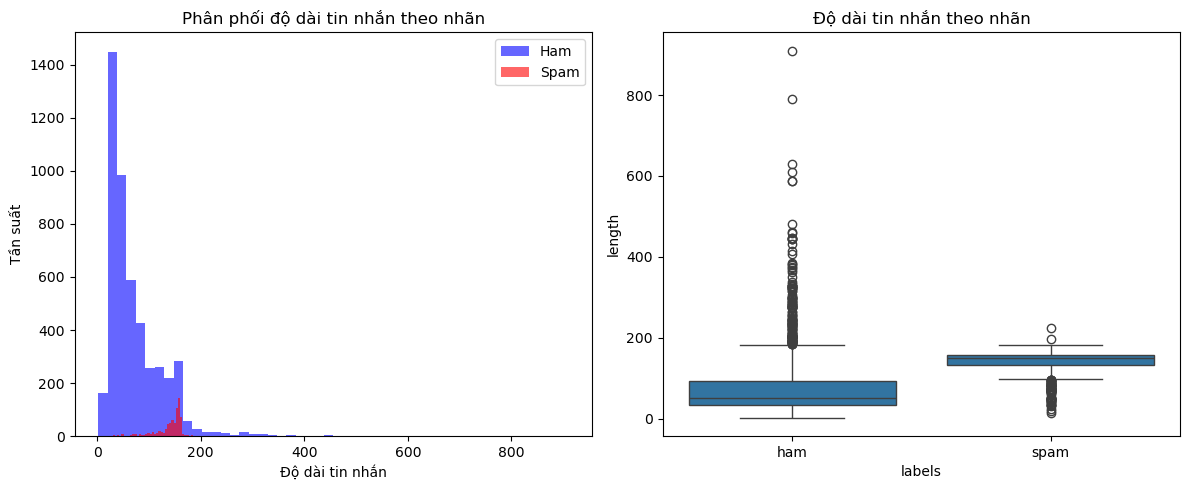

In [6]:
# PHÂN TÍCH KHÁM PHÁ DỮ LIỆU
plt.figure(figsize=(12, 5))

# Phân phối độ dài tin nhắn theo nhãn
plt.subplot(1, 2, 1)
message[message['labels'] == 'ham']['length'].plot(bins=50, kind='hist', color='blue', alpha=0.6, label='Ham')
message[message['labels'] == 'spam']['length'].plot(bins=50, kind='hist', color='red', alpha=0.6, label='Spam')
plt.xlabel('Độ dài tin nhắn')
plt.ylabel('Tần suất')
plt.title('Phân phối độ dài tin nhắn theo nhãn')
plt.legend()

# Box plot độ dài tin nhắn theo nhãn
plt.subplot(1, 2, 2)
sns.boxplot(x='labels', y='length', data=message)
plt.title('Độ dài tin nhắn theo nhãn')
plt.tight_layout()
plt.show()

In [7]:
# CHIA DỮ LIỆU
# Chia dữ liệu thành tập huấn luyện (80%) và kiểm tra (20%)
msg_train, msg_test, label_train, label_test = train_test_split(
    message['message'], message['labels'], test_size=0.2, random_state=42, stratify=message['labels']
)

print(f"\nKích thước tập huấn luyện: {len(msg_train)}")
print(f"Kích thước tập kiểm tra: {len(msg_test)}")
print(f"Phân phối nhãn trong tập huấn luyện: {pd.Series(label_train).value_counts()}")
print(f"Phân phối nhãn trong tập kiểm tra: {pd.Series(label_test).value_counts()}")


Kích thước tập huấn luyện: 4457
Kích thước tập kiểm tra: 1115
Phân phối nhãn trong tập huấn luyện: labels
ham     3859
spam     598
Name: count, dtype: int64
Phân phối nhãn trong tập kiểm tra: labels
ham     966
spam    149
Name: count, dtype: int64


In [8]:
# XÂY DỰNG PIPELINE VỚI NAIVE BAYES
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Chuyển đổi văn bản thành Bag-of-Words
    ('tfidf', TfidfTransformer()),  # Áp dụng trọng số TF-IDF
    ('classifier', MultinomialNB()),  # Áp dụng thuật toán Naive Bayes
])

# XÂY DỰNG PIPELINE VỚI LOGISTIC REGRESSION
lr_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Chuyển đổi văn bản thành Bag-of-Words
    ('tfidf', TfidfTransformer()),  # Áp dụng trọng số TF-IDF
    ('classifier', LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)),  # Áp dụng Logistic Regression
])

In [9]:
# HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH NAIVE BAYES
print("\nHUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH NAIVE BAYES")
start_time = time.time()
nb_pipeline.fit(msg_train, label_train)
nb_training_time = time.time() - start_time
print(f"Thời gian huấn luyện: {nb_training_time:.2f} giây")

# Đánh giá mô hình Naive Bayes
nb_predictions = nb_pipeline.predict(msg_test)
nb_report = classification_report(label_test, nb_predictions, output_dict=True)
print("\nBáo cáo phân loại mô hình Naive Bayes:")
print(classification_report(label_test, nb_predictions))

nb_cm = confusion_matrix(label_test, nb_predictions)
print("\nMa trận nhầm lẫn của mô hình Naive Bayes:")
print(nb_cm)


HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH NAIVE BAYES
Thời gian huấn luyện: 30.49 giây

Báo cáo phân loại mô hình Naive Bayes:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.71      0.83       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115


Ma trận nhầm lẫn của mô hình Naive Bayes:
[[966   0]
 [ 43 106]]


In [10]:
# HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION
print("\nHUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION")
start_time = time.time()
lr_pipeline.fit(msg_train, label_train)
lr_training_time = time.time() - start_time
print(f"Thời gian huấn luyện: {lr_training_time:.2f} giây")

# Đánh giá mô hình Logistic Regression
lr_predictions = lr_pipeline.predict(msg_test)
lr_report = classification_report(label_test, lr_predictions, output_dict=True)
print("\nBáo cáo phân loại mô hình Logistic Regression:")
print(classification_report(label_test, lr_predictions))

lr_cm = confusion_matrix(label_test, lr_predictions)
print("\nMa trận nhầm lẫn của mô hình Logistic Regression:")
print(lr_cm)


HUẤN LUYỆN VÀ ĐÁNH GIÁ MÔ HÌNH LOGISTIC REGRESSION
Thời gian huấn luyện: 31.33 giây

Báo cáo phân loại mô hình Logistic Regression:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Ma trận nhầm lẫn của mô hình Logistic Regression:
[[965   1]
 [ 18 131]]



SO SÁNH HAI MÔ HÌNH:
             Metrics  Naive Bayes  Logistic Regression
0           Accuracy     0.961435             0.982960
1   Precision (spam)     1.000000             0.992424
2      Recall (spam)     0.711409             0.879195
3    F1-score (spam)     0.831373             0.932384
4  Training Time (s)    30.488817            31.330570


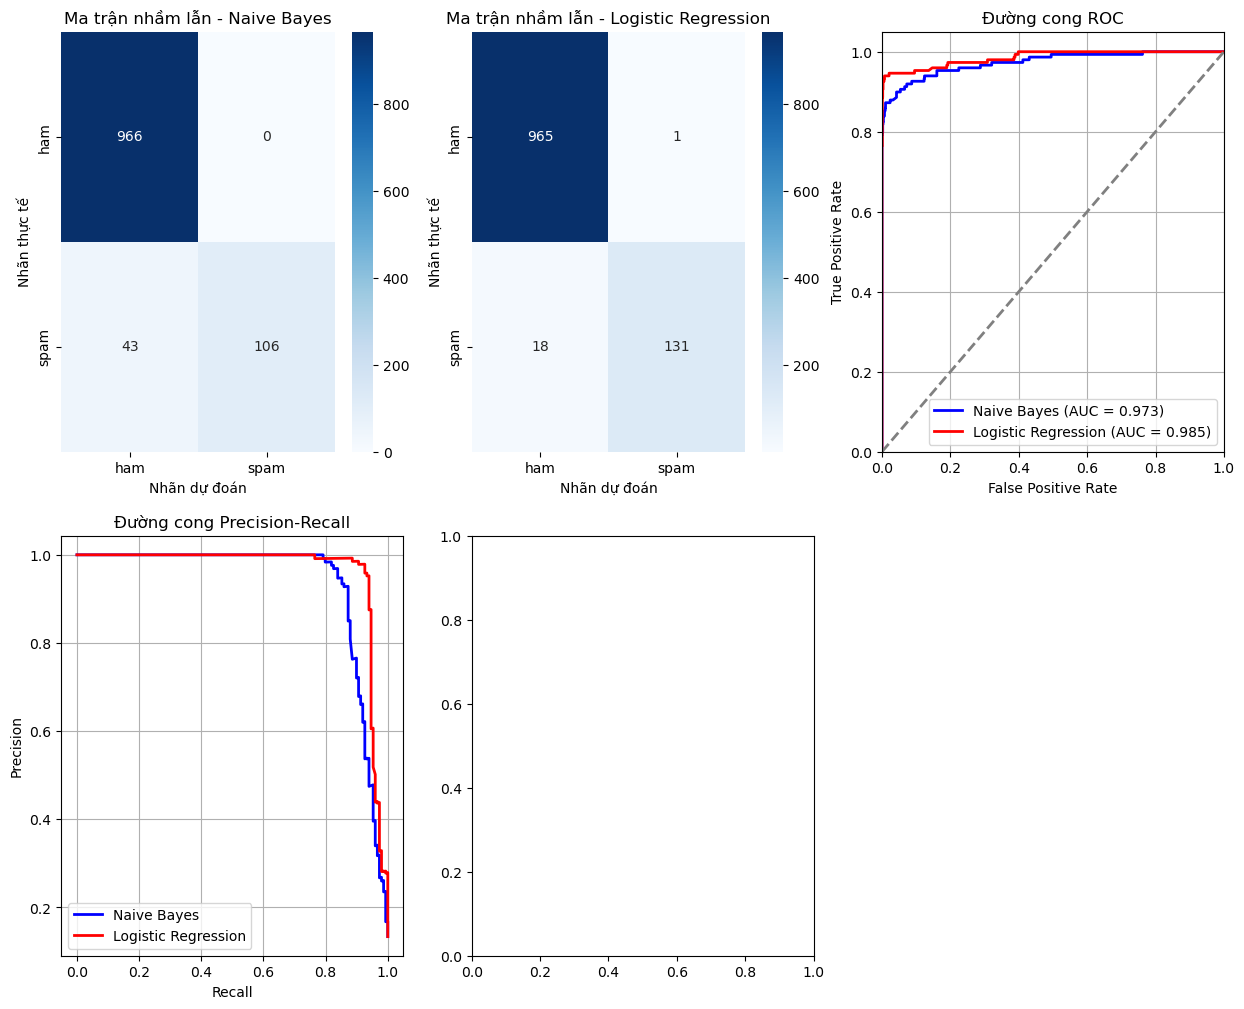

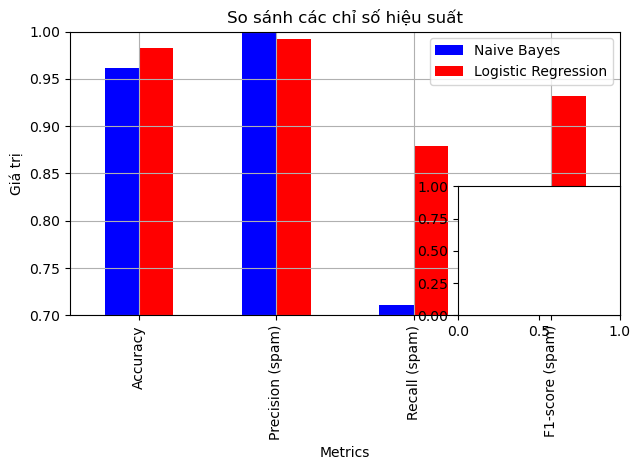

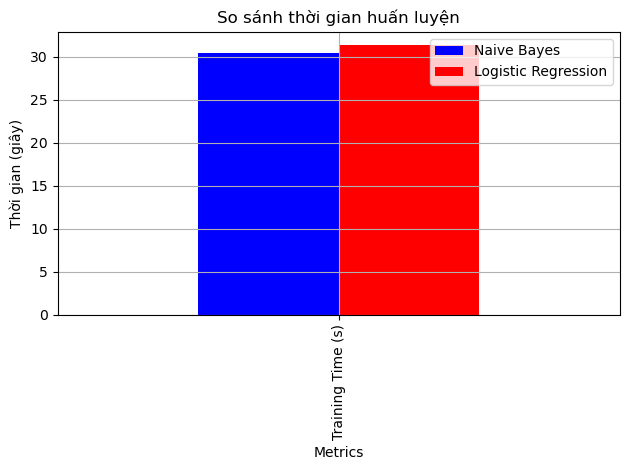

In [11]:
# SO SÁNH HAI MÔ HÌNH
comparison_df = pd.DataFrame({
    'Metrics': ['Accuracy', 'Precision (spam)', 'Recall (spam)', 'F1-score (spam)', 'Training Time (s)'],
    'Naive Bayes': [
        nb_report['accuracy'], 
        nb_report['spam']['precision'], 
        nb_report['spam']['recall'], 
        nb_report['spam']['f1-score'],
        nb_training_time
    ],
    'Logistic Regression': [
        lr_report['accuracy'], 
        lr_report['spam']['precision'], 
        lr_report['spam']['recall'], 
        lr_report['spam']['f1-score'],
        lr_training_time
    ]
})

print("\nSO SÁNH HAI MÔ HÌNH:")
print(comparison_df)

# ĐÁNH GIÁ CHI TIẾT
# Tính xác suất dự đoán cho mô hình Naive Bayes và Logistic Regression
nb_proba = nb_pipeline.predict_proba(msg_test)[:, 1]  # Xác suất thuộc lớp "spam"
lr_proba = lr_pipeline.predict_proba(msg_test)[:, 1]  # Xác suất thuộc lớp "spam"

# Tính ROC và Precision-Recall
nb_fpr, nb_tpr, _ = roc_curve(label_test == 'spam', nb_proba)
nb_roc_auc = auc(nb_fpr, nb_tpr)

lr_fpr, lr_tpr, _ = roc_curve(label_test == 'spam', lr_proba)
lr_roc_auc = auc(lr_fpr, lr_tpr)

nb_precision, nb_recall, _ = precision_recall_curve(label_test == 'spam', nb_proba)
lr_precision, lr_recall, _ = precision_recall_curve(label_test == 'spam', lr_proba)

# TRỰC QUAN HÓA KẾT QUẢ
plt.figure(figsize=(15, 12))

# Ma trận nhầm lẫn của Naive Bayes
plt.subplot(2, 3, 1)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Ma trận nhầm lẫn - Naive Bayes')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')

# Ma trận nhầm lẫn của Logistic Regression
plt.subplot(2, 3, 2)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Ma trận nhầm lẫn - Logistic Regression')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')

# Đường cong ROC
plt.subplot(2, 3, 3)
plt.plot(nb_fpr, nb_tpr, color='blue', lw=2, label=f'Naive Bayes (AUC = {nb_roc_auc:.3f})')
plt.plot(lr_fpr, lr_tpr, color='red', lw=2, label=f'Logistic Regression (AUC = {lr_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC')
plt.legend(loc="lower right")
plt.grid(True)

# Đường cong Precision-Recall
plt.subplot(2, 3, 4)
plt.plot(nb_recall, nb_precision, color='blue', lw=2, label='Naive Bayes')
plt.plot(lr_recall, lr_precision, color='red', lw=2, label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Đường cong Precision-Recall')
plt.legend(loc="best")
plt.grid(True)

# Biểu đồ so sánh các chỉ số hiệu suất
plt.subplot(2, 3, 5)
comparison_df.set_index('Metrics').iloc[0:4].plot(kind='bar', color=['blue', 'red'])
plt.title('So sánh các chỉ số hiệu suất')
plt.ylabel('Giá trị')
plt.ylim([0.7, 1.0])
plt.grid(True)
plt.tight_layout()

# Biểu đồ so sánh thời gian huấn luyện
plt.subplot(2, 3, 6)
comparison_df.set_index('Metrics').iloc[4:].plot(kind='bar', color=['blue', 'red'])
plt.title('So sánh thời gian huấn luyện')
plt.ylabel('Thời gian (giây)')
plt.grid(True)

plt.tight_layout()
plt.show()